### Part 1: Import recource & Hyperparameter

In [1]:
# Comman library
import math
import random
import numpy as np
import gym
from gym import spaces
import cv2
from collections import deque
import datetime

In [2]:
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [3]:
# Tool for image preprocessing
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Device and variable for parameter transferring
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if torch.cuda.is_available() else autograd.Variable(*args, **kwargs)

cuda


In [5]:
# Hyper-parameter
BATCH_SIZE = 32         # Minibatch size 
GAMMA = 0.99            # Discount factor 
LR = 1e-4               # Learning rate
UPDATE_TARGET = 1000    # How often to update the target-network
NUM_FRAME = 1000000 

In [6]:
# Memory-parameter
BUFFER_SIZE = int(1e5)  # Replay buffer size 
REPLAY_INITIAL = 10000  # Random sampling period

In [7]:
# Epsilon
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 30000


# EPS_BY_FRAME = lambda frame_idx : max(EPS_END, EPS_START - frame_idx * (EPS_START - EPS_END)/EPS_DECAY)
EPS_BY_FRAME = lambda frame_idx : EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx / EPS_DECAY)

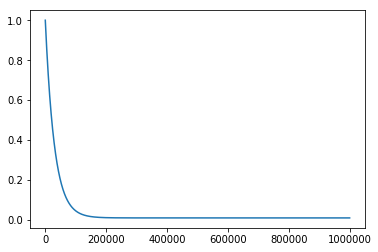

In [8]:
# Plot changing epsilon
plt.plot([EPS_BY_FRAME(i) for i in range(1000000)])

In [9]:
# Tensor board
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/dqn_pong_3action')

---
### Part 2: Save & Load model

In [10]:
class SaveLoad():
    
    def __init__(self):
        self.directory = "./saved_model/"
        self.PATH = self.directory + "model_dqn_3action.pt"
        
    def save_models(self, qnetwork_local, qnetwork_target, optimizer, losses):
        torch.save({
        'model_local_state_dict': qnetwork_local.state_dict(),
        'model_target_state_dict': qnetwork_target.state_dict(),
        'optimizer_local_state_dict': optimizer.state_dict(),
        'losses': losses,
        }, self.PATH)
        print('NN Models have been saved to: ', self.PATH)
        return 

    def load_models(self, qnetwork_local, qnetwork_target, optimizer): 
        losses = []
        try:
            f = open(self.PATH)
            f.close()
        except IOError:
            print('Could not find file in dir.')
            return
        print('Loading NN\'s from:', self.PATH)
        checkpoint = torch.load(self.PATH)
        qnetwork_local.load_state_dict(checkpoint['model_local_state_dict'])
        qnetwork_target.load_state_dict(checkpoint['model_target_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_local_state_dict'])
        losses = checkpoint['losses']
        return [qnetwork_local, qnetwork_target, optimizer, losses]
save_load = SaveLoad()

---
### Part 3: Image preprocessing & CNN

In [11]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        print(np.shape(old_shape))
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)


In [12]:
def make_atari(env_id):
    env = gym.make(env_id)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [13]:
env_id = "PongDeterministic-v4"
env    = make_atari(env_id)
env    = WarpFrame(env)
env    = wrap_pytorch(env)

(3,)


In [14]:
# Environment-parameter
input_shape = env.observation_space.shape
num_action  = 3
VALID_ACTIONS = [0, 2, 3]

In [15]:
class CNN(nn.Module):
    
    def __init__(self, input_shape, num_action):
        super(CNN, self).__init__()
        
        self.input_shape = input_shape
        self.num_action = num_action
        
        self.features = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_action)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

In [16]:
# Generate Q-network
if torch.cuda.is_available():
    qnetwork_local = CNN(input_shape, num_action).cuda()
    qnetwork_target  = CNN(input_shape, num_action).cuda()
else:
    qnetwork_local = CNN(input_shape, num_action)
    qnetwork_target = CNN(input_shape, num_action)
optimizer = optim.Adam(qnetwork_local.parameters(), lr=LR)

---
### Part 4: Replay memory

In [17]:
class Memory(object):
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
         
    def add(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.memory)

---
### Part 5: Agent

In [18]:
class Agent:
  
    def __init__(self, input_shape, num_action):
        """Initialize an Agent object.
          
          Params
          ======
              input_shape: input frame shape
              num_action: dimension of each action
          """
        self.input_shape = input_shape
        self.num_action = num_action

        self.memory = Memory(BUFFER_SIZE, BATCH_SIZE)

    def step(self, batch_size, gamma, losses):
        """Change current frame to next one and get loss."""

        # Learn DQN and return loss
        if len(self.memory) >= REPLAY_INITIAL:
            loss = self.dqn_loss(BATCH_SIZE, GAMMA)
            losses.append(loss.data)     
     
    def dqn_loss(self, batch_size, gamma):
        """Calculate loss using DQN"""
        state, action, reward, next_state, done = self.memory.sample(batch_size)

        state      = Variable(torch.FloatTensor(np.float32(state)))
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
        action     = Variable(torch.LongTensor(action))
        reward     = Variable(torch.FloatTensor(reward))
        done       = Variable(torch.FloatTensor(done))

        # DQN
        q_values      = qnetwork_local(state)
        next_q_values = qnetwork_target(next_state)

        q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value     = next_q_values.max(1)[0]
        expected_q_value = reward + gamma * next_q_value * (1 - done)
        
        loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Train/Loss', loss, frame_idx)    # --> Tensor board
        
        return loss

    
    def act(self, state, eps):
        if random.random() > eps:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = qnetwork_local.forward(state)   
            action  = q_value.max(1)[1].cpu().data[0]
        else:
            action = random.randrange(self.num_action)
            
        return action

    def update_target(self):
        """Update target network every UPDATE_TARGET steps"""
        qnetwork_target.load_state_dict(qnetwork_local.state_dict())
        

---
### Part 6: Plot & Timer


In [19]:
def plot(frame_idx, rewards, losses, episode_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Frame %s. Reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('Loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('Episode time')
    plt.plot(episode_time)
    plt.show()

In [20]:
def time_stamp():
    time = datetime.datetime.now()
    time = time.strftime("%H:%M:%S")
    return time

---
### Part 7: Training

In [21]:
agent = Agent(input_shape=input_shape, num_action=num_action)
qnetwork_target.load_state_dict(qnetwork_local.state_dict())

<All keys matched successfully>

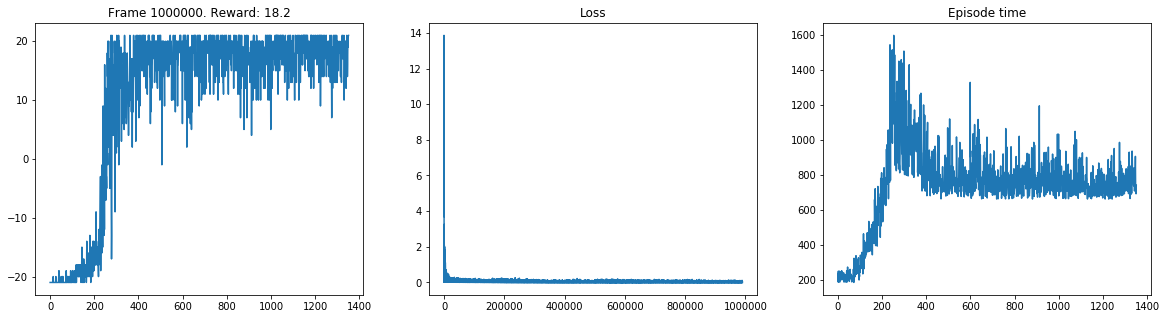

Start time is:  17:14:12
Current time is:  20:40:14
Training completed at:  20:40:23


In [22]:
losses = []
all_rewards = []
episode_reward = 0
episode_time = []
episode_time_counter = 0

state = env.reset()
start_time = time_stamp()
print("Start time is: ", start_time)
for frame_idx in range(1, NUM_FRAME + 1):
    # Epsilon
    eps = EPS_BY_FRAME(frame_idx)
    # Act
    action = agent.act(state, eps)
    # Get next experience
    next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
    # Put experience into memory
    agent.memory.add(state, action, reward, next_state, done)
    # Update state and reward
    state = next_state
    episode_reward += reward
    # Calculate loss
    agent.step(BATCH_SIZE, GAMMA, losses)
    # Counter time for each episode
    episode_time_counter += 1

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        writer.add_scalar('Train/Reward', episode_reward, frame_idx)    # --> Tensor board
        episode_reward = 0
        
        episode_time.append(episode_time_counter)
        writer.add_scalar('Train/Episode_time', episode_time_counter, frame_idx)    # --> Tensor board
        episode_time_counter = 0
        
    if frame_idx % 10000 == 0:
        save_load.save_models(qnetwork_local, qnetwork_target, optimizer, losses)
        current_time = time_stamp()
        plot(frame_idx, all_rewards, losses, episode_time)
        print('Start time is: ', start_time)
        print('Current time is: ', current_time)
        
    if frame_idx % UPDATE_TARGET == 0:
        agent.update_target()
        
    if frame_idx == NUM_FRAME:
        end_time = time_stamp()
        print("Training completed at: ", end_time)
        

In [ ]:
writer.close()

---
### Part 8: Evaluation

In [ ]:
env_id = "PongDeterministic-v4"
env    = make_atari(env_id)
env    = WarpFrame(env)
env    = wrap_pytorch(env)
#env    = MaxAndSkipEnv(env, skip=1)

models = save_load.load_models(qnetwork_local, qnetwork_target, optimizer)
if models != None:
    qnetwork_local = models[0]

In [ ]:
episode_reward = 0
all_rewards = []

for i in range(100):
    state = env.reset()

    for j in range(30000):
        action = agent.act(state, 0)
        state, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            all_rewards.append(episode_reward)
            episode_reward = 0
            break 
    if i % 5 == 0:
        clear_output(wait=True)
        epi_avg = sum(all_rewards) / len(all_rewards)
        print("Average: ", epi_avg)
        plt.plot(all_rewards)
        plt.ylabel('Rewards')
        plt.show()
    env.close()